## Load relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Define the given PDF function

In [2]:
def my_pdf(x):
    return 0.5 * np.exp(-np.abs(x))

## Define a function that implements the specified Random Walk Metropolis algorithm

In [3]:
def rwm_algorithm(N, x0, s):
    results = pd.DataFrame({'Iteration': np.arange(1, N+1), 'xi_Values': np.nan * np.ones(N)})

    if not isinstance(x0, list):
        x0 = [x0]  # Convert x0 to a list for iteration

    # Assign the initial value without using chained indexing
    results.at[0, 'xi_Values'] = x0[0][0] if np.asarray(x0[0]).ndim > 0 else x0[0]

    for i in range(1, N):
        random_nums = np.random.normal(loc=results.at[i-1, 'xi_Values'], scale=s, size=len(x0))
        ratio = my_pdf(random_nums) / my_pdf(results.at[i-1, 'xi_Values'])
        u = np.random.uniform(size=len(x0))

        mask = u < ratio

        # Assign the values without using chained indexing
        results.at[i, 'xi_Values'] = np.where(mask, random_nums, results.at[i-1, 'xi_Values'])

    return results


# PART A

In [4]:
# Set initial parameters
x0 = 10
s = 1
N = 10000

# Store output into variable 'results' with 2 columns: 'Iteration' and 'xi_Values'
results = rwm_algorithm(N, x0, s)

### PLOTTING

In [5]:
# Generate actual x and y values using the pdf f(x)
x_values_actual = np.linspace(-20, 20, 1000)
y_values_actual = my_pdf(x_values_actual)

# Create a data frame for simulated values
simulated_df = pd.DataFrame({
    'x': results['xi_Values'],
    'y': np.nan,
    'Source': 'Simulated'
})

In [6]:
# Create a data frame for original PDF values
original_df = pd.DataFrame({
    'x': x_values_actual,
    'y': y_values_actual,
    'Source': 'Actual PDF'
})

In [7]:
# Combine both data frames into a single 'df' consisting of columns 'x', 'y', and 'Source'
df = pd.concat([simulated_df, original_df], ignore_index=True)

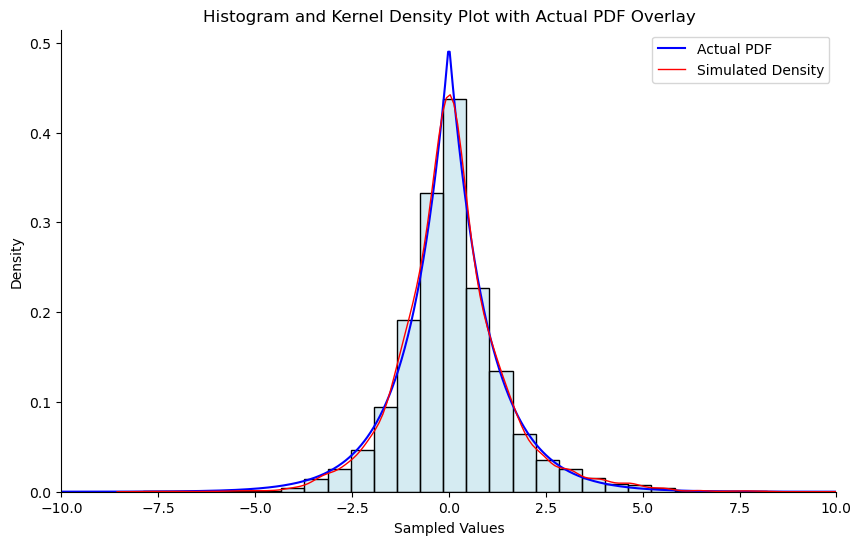

In [8]:
# Using the combined data frame 'df', plot histogram, kernel density to visualize estimates of f(x)
# Along with the actual PDF graph of f(x) = (1/2)exp(-|x|) to visualize the quality of the estimate

plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['Source'] == 'Simulated'], x='x', stat='density', bins=30, color='lightblue', edgecolor='black', alpha=0.5)
sns.lineplot(data=df[df['Source'] == 'Actual PDF'], x='x', y='y', color='blue', label='Actual PDF', linewidth=1.5)
sns.kdeplot(data=df[df['Source'] == 'Simulated'], x='x', color='red', label='Simulated Density', linewidth=1, warn_singular=False)
plt.title('Histogram and Kernel Density Plot with Actual PDF Overlay')
plt.xlabel('Sampled Values')
plt.xlim(-10, 10)
plt.legend()
sns.despine()
plt.show()

# PART B

In [9]:
# Function to calculate R-hat value
def calc_r_hat(N, s, J):
    np.random.seed(71)

    # Generate J sequences with different random initial values
    initial_values = np.random.uniform(-10, 10, J)  # Record initial values for verification
    chain_results = [rwm_algorithm(N, initial_values, s) for _ in range(J)]

    # Function to compute sample mean (Mj) for a given chain j
    compute_Mj = lambda chain: np.mean(chain['xi_Values'])
    Mj = np.array([compute_Mj(chain) for chain in chain_results], dtype=np.float64)

    # Function to compute within-sample variance (Vj) for a given chain j
    compute_Vj = lambda chain, sample_mean: np.var(chain['xi_Values'], ddof=1)
    Vj = np.array([compute_Vj(chain, mean) for chain, mean in zip(chain_results, Mj)], dtype=np.float64)

    # Calculate overall within-sample variance (W)
    W = np.mean(Vj)

    # Calculate overall sample mean (M)
    M = np.mean(Mj)

    # Calculate between-sample variance (B)
    B = np.mean((Mj - M)**2)

    # Calculate R-hat value
    R_hat = np.sqrt((B + W) / W)

    return R_hat

# Retrieve final R-hat value
result = calc_r_hat(N=2000, s=0.001, J=4)
print(result)

1.0459214760698152


In [10]:
# Function to calculate R-hat values over a grid of s values
def calculate_r_hat_over_grid(N, s_values, J):
    r_hat_values = []

    for s in s_values:
        r_hat = calc_r_hat(N, s, J)
        r_hat_values.append({'s': s, 'R_hat': r_hat})

    return pd.DataFrame(r_hat_values)

In [11]:
# Grid of s values
s_grid = np.linspace(0.001, 1, 100)

# Calculate R-hat values over the grid
r_hat_df = calculate_r_hat_over_grid(N=2000, s_values=s_grid, J=4)

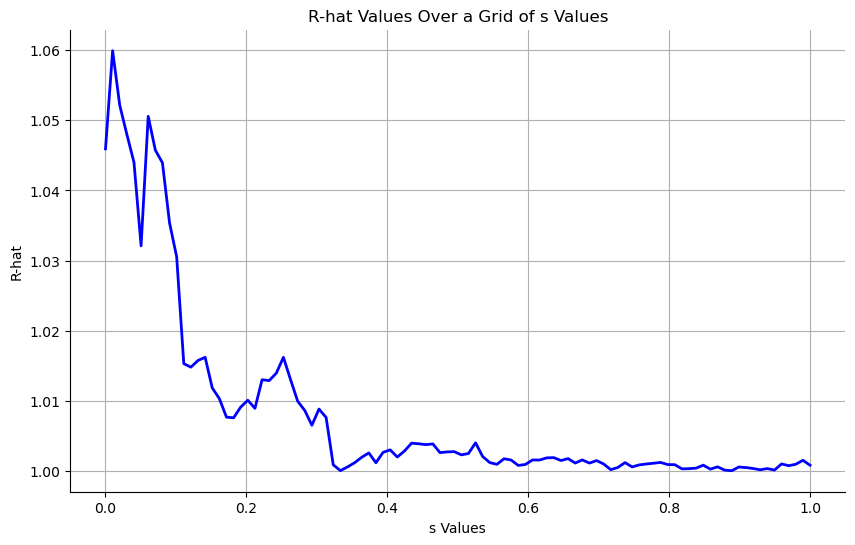

In [12]:
# Plot R-hat values over the grid of s values
plt.figure(figsize=(10, 6))
sns.lineplot(data=r_hat_df, x='s', y='R_hat', color='blue', linewidth=2)
plt.title('R-hat Values Over a Grid of s Values')
plt.xlabel('s Values')
plt.ylabel('R-hat')
plt.grid(True)
sns.despine()
plt.show()

In [15]:
# Calculate Monte Carlo estimates of mean and standard deviation
monte_carlo_mean = results['xi_Values'].mean()
monte_carlo_std = results['xi_Values'].std()

# Print the results
print(f"Monte Carlo Estimate of Mean: {monte_carlo_mean}")
print(f"Monte Carlo Estimate of Standard Deviation: {monte_carlo_std}")

Monte Carlo Estimate of Mean: 0.07342596005002613
Monte Carlo Estimate of Standard Deviation: 1.3835674951787764
